In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install -U rocksdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 41.8 MB/s eta 0:00:00


In [40]:
import re, json, random
from dataclasses import dataclass
from rocksdict import Rdict, WriteBatch
import os, shutil
import threading, time
from collections import deque

# -------------------- storage --------------------
class RocksStore:
    def __init__(self, db_path: str):
        self.db_path = db_path
        self.db = Rdict(db_path)

    def read(self, k): return self.db[k]
    def write(self, k, v): self.db[k] = v
    def keys(self): return self.db.keys()
    def write_batch(self, wb: WriteBatch): self.db.write(wb)
    def close(self): self.db.close()


# -------------------- input parsing + loading --------------------
class InputKV:
    PAT = re.compile(r'^\s*KEY:\s*(.+?)\s*,\s*VALUE:\s*(\{.*\})\s*$')
    FIX = staticmethod(lambda s: re.sub(r'([{,]\s*)([A-Za-z_]\w*)\s*:', r'\1"\2":', s))

    @classmethod
    def iter_items(cls, path: str):
        with open(path, encoding="utf-8") as f:
            for ln in f:
                m = cls.PAT.match(ln)
                if m:
                    yield m.group(1).strip(), json.loads(cls.FIX(m.group(2)))

    @classmethod
    def load_into(cls, store: RocksStore, *input_paths: str):
        wb = WriteBatch()
        for p in input_paths:
            for k, v in cls.iter_items(p):
                wb.put(k, v)
        store.write_batch(wb)

    @classmethod
    def scan_stats(cls, path: str):
        ks, inn = [], set()
        for k, v in cls.iter_items(path):
            ks.append(k)
            if isinstance(v, dict): inn |= v.keys()
        return ks, inn


# -------------------- verification --------------------
class DBVerifier:
    @staticmethod
    def verify(store: RocksStore, input1: str, input2: str, subtract_n: int = 4):
        k1,i1 = InputKV.scan_stats(input1); k2,i2 = InputKV.scan_stats(input2)
        exp_rows, exp_inn = len(k1) + len(k2) - subtract_n, (i1 | i2)

        dbk = list(store.keys()); dbs = set(dbk)
        act_rows = len(dbk) - subtract_n
        assert act_rows == exp_rows, f"Count mismatch: expected {exp_rows}, got {act_rows} (raw={len(dbk)})"

        db_inn = set()
        for k in dbs:
            v = store.read(k)
            assert isinstance(v, dict) and v, f"Bad/empty value for key {k}: {v}"
            db_inn |= v.keys()

        miss = exp_inn - db_inn
        assert not miss, f"Missing inner keys in DB values: {miss}"
        print("✅ Verified:", "rows", act_rows, "| inner keys", sorted(db_inn))


# -------------------- workload parsing -> callable txns --------------------
@dataclass
class TxnTemplate:
    inputs: list
    fn: callable  # fn(READ, WRITE, **inputs)


class Workload:
    _KEY_LINE = re.compile(r'^\s*KEY:\s*(.+?)\s*,\s*VALUE:')

    def __init__(self, txns: list[TxnTemplate], keys: list[str]):
        self.txns = txns
        self.keys = keys
        self.key_nums = {}
        self.keys_by_letter = {}
        self.key_tree = {}
        self.keys_sorted = []
        self._mu_by_letter = None
        self._index_keys()

    @staticmethod
    def _split_key(k: str):
        parts = k.split("_")
        letter = parts[0]
        nums = tuple(int(x) for x in parts[1:] if x)
        return letter, nums

    def _index_keys(self):
        kb, kn, kt = self.keys_by_letter, self.key_nums, self.key_tree
        for k in self.keys:
            L, nums = self._split_key(k)
            kn[k] = nums
            kb.setdefault(L, []).append(k)
            node = kt.setdefault(L, {})
            for n in nums:
                node = node.setdefault(n, {})
            node.setdefault("_", []).append(k)

        for L, lst in kb.items():
            lst.sort(key=kn.__getitem__)
        self.keys_sorted = sorted(self.keys, key=lambda k: (k.split("_", 1)[0], kn[k]))

    @classmethod
    def _read_keys_from_inputs(cls, *input_paths: str):
        out = []
        for p in input_paths:
            with open(p, encoding="utf-8") as f:
                for ln in f:
                    m = cls._KEY_LINE.match(ln)
                    if m:
                        out.append(m.group(1).strip())
        return out

    @staticmethod
    def _parse_txns(path: str):
        txs, in_txn, inputs, body = [], False, None, None

        def compile_txn(inputs, body_lines, file=path):
            code = compile("\n".join(body_lines), file, "exec")
            def txn(READ, WRITE, **kw):
                env = {"READ": READ, "WRITE": WRITE, **kw}
                exec(code, {}, env)
            return TxnTemplate(inputs, txn)

        with open(path, "r", encoding="utf-8") as f:
            for raw in f:
                line = raw.partition("//")[0].rstrip("\n")
                s = line.strip()
                if not s or s == "WORKLOAD":
                    continue

                if not in_txn:
                    if s == "END": break
                    if s.startswith("TRANSACTION"):
                        p = s.find("INPUTS:")
                        inside = s[p+7:].strip()
                        if inside.endswith(")"): inside = inside[:-1]
                        inputs = [x.strip() for x in inside.split(",") if x.strip()]
                        body, in_txn = [], True
                    continue

                if s == "END":
                    txs.append(compile_txn(inputs, body))
                    in_txn = False
                    continue

                body.append(line)

        if in_txn:
            raise ValueError(f"Unclosed TRANSACTION in {path}")
        return txs

    @classmethod
    def load(cls, workload_path: str, *input_paths: str):
        txns = cls._parse_txns(workload_path)
        keys = cls._read_keys_from_inputs(*input_paths) if input_paths else []
        return cls(txns, keys)

    @staticmethod
    def _infer_letter(input_name: str):
        if input_name in ("FROM_KEY", "TO_KEY"):
            return "A"
        return input_name[0]

    # NEW: shuffle keys per letter and set mu to the middle index
    def prepare_hotspots(self, seed: int | None = None, shuffle: bool = True):
        rng = random.Random(seed)
        mu = {}
        for L, lst in self.keys_by_letter.items():
            if shuffle:
                rng.shuffle(lst)
            mu[L] = (len(lst) // 2) if lst else 0
        self._mu_by_letter = mu
        return mu

    # NEW: sigma is % based -> sigma_idx = sigma * len(lst)
    def generate_txn_inputs(self, n: int, p: float, sigma: float, *,
                            key_letter_map: dict | None = None, seed: int | None = None,
                            shuffle_on_prepare: bool = True):
        rng = random.Random(seed)

        if self._mu_by_letter is None:
            self.prepare_hotspots(seed=seed, shuffle=shuffle_on_prepare)

        mu = self._mu_by_letter
        kb = self.keys_by_letter
        txs = self.txns
        m = len(txs) or 1

        out = []
        for i in range(n):
            t = txs[i % m]
            kw = {}
            for inp in t.inputs:
                L = (key_letter_map.get(inp) if key_letter_map else None) or self._infer_letter(inp)
                lst = kb[L]
                c = mu[L]
                if rng.random() < p:
                    sigma_idx = sigma * len(lst)
                    idx = c if sigma_idx == 0 else int(round(rng.gauss(c, sigma_idx)))
                    if idx < 0: idx = 0
                    elif idx >= len(lst): idx = len(lst) - 1
                else:
                    idx = rng.randrange(len(lst))
                kw[inp] = lst[idx]
            out.append((t, kw))
        return out


# -------------------- Conservative 2PL (exclusive locks only) --------------------
class LockTable:
    def __init__(self):
        self._m = threading.Lock()
        self._locks = {}  # key -> threading.Lock()

    def _lock(self, key):
        with self._m:
            lk = self._locks.get(key)
            if lk is None:
                lk = self._locks[key] = threading.Lock()
            return lk

    def try_acquire_all(self, keys):
        acquired = []
        for k in keys:
            lk = self._lock(k)
            if lk.acquire(False):
                acquired.append(lk)
            else:
                for a in reversed(acquired):
                    a.release()
                return None
        return acquired

    @staticmethod
    def release_all(acquired):
        for lk in reversed(acquired):
            lk.release()


class Conservative2PLExecutor:
    def __init__(self, store, *, base_backoff=0.0002, max_backoff=0.02, cap_exp=16):
        self.store = store
        self.locks = LockTable()
        self.base_backoff = base_backoff
        self.max_backoff = max_backoff
        self.cap_exp = cap_exp

    def _acquire_retry(self, keys, rng):
        tries = 0
        while True:
            acquired = self.locks.try_acquire_all(keys)
            if acquired is not None:
                return acquired, tries
            tries += 1
            d = min(self.max_backoff, self.base_backoff * (2 ** min(tries, self.cap_exp)))
            d *= rng.uniform(0.5, 1.5)  # jitter to prevent livelock
            time.sleep(d)

    def run(self, jobs, n_threads: int):
      q = deque(jobs)
      q_lock = threading.Lock()

      locals_ = [{
          "commits": 0,
          "retries": 0,
          "errors": 0,
          "txn_count": 0,
          "total_rt_ns": 0,   # sum of (finish - start) for commit/abort
      } for _ in range(n_threads)]

      def worker(tid):
          rng = random.Random(12345 + tid)
          s = locals_[tid]

          while True:
              with q_lock:
                  if not q:
                      return
                  tmpl, kw = q.popleft()

              # Average Response Time: start -> commit/abort
              t0 = time.perf_counter_ns()

              keys = sorted(set(kw.values()))
              acquired, retries = self._acquire_retry(keys, rng)

              ok = False
              try:
                  tmpl.fn(self.store.read, self.store.write, **kw)
                  ok = True
              except Exception:
                  s["errors"] += 1
                  ok = False
              finally:
                  self.locks.release_all(acquired)

                  dt = time.perf_counter_ns() - t0
                  s["txn_count"] += 1
                  s["total_rt_ns"] += dt
                  s["retries"] += retries
                  if ok:
                      s["commits"] += 1

      wall_t0 = time.perf_counter()

      threads = [threading.Thread(target=worker, args=(i,)) for i in range(n_threads)]
      for t in threads: t.start()
      for t in threads: t.join()

      wall_t1 = time.perf_counter()
      elapsed_s = wall_t1 - wall_t0

      stats = {"commits": 0, "retries": 0, "errors": 0, "txn_count": 0, "total_rt_ns": 0}
      for s in locals_:
          stats["commits"] += s["commits"]
          stats["retries"] += s["retries"]
          stats["errors"] += s["errors"]
          stats["txn_count"] += s["txn_count"]
          stats["total_rt_ns"] += s["total_rt_ns"]

      stats["avg_rt_ms"] = (stats["total_rt_ns"] / stats["txn_count"]) / 1e6 if stats["txn_count"] else 0.0

      stats["elapsed_s"] = elapsed_s
      stats["throughput_tps"] = (stats["txn_count"] / elapsed_s) if elapsed_s > 0 else 0.0   # commit+abort
      stats["retries_throughput_tps"] = (stats["retries"] / elapsed_s) if elapsed_s > 0 else 0.0

      return stats

In [41]:
DB_PATH = "/mnt/data/rocks_inputs_db"
workload1 = "/content/drive/MyDrive/223/workloads/workload1/workload1.txt"
input1 = "/content/drive/MyDrive/223/workloads/workload1/input1.txt"
workload2 = "/content/drive/MyDrive/223/workloads/workload2/workload2.txt"
input2 = "/content/drive/MyDrive/223/workloads/workload2/input2.txt"

contention = float(input("Specify contention level: "))
print("Number of threads available: " + str(os.cpu_count()))
n_threads = int(input("Enter number of threads: "))


try: store.close()
except: pass

shutil.rmtree(DB_PATH, ignore_errors=True)  # DB_PATH is a folder for rocksdict
store = RocksStore(DB_PATH)

InputKV.load_into(store, input1, input2)

w1 = Workload.load(workload1, input1)
jobs1 = w1.generate_txn_inputs(n=100_000, p=contention, sigma = 0.2, seed=42)

w2 = Workload.load(workload2, input2)
jobs2 = w2.generate_txn_inputs(n=100_000, p=contention, sigma=0.2, seed=42)

executor = Conservative2PLExecutor(store)
stats = executor.run(jobs1, n_threads)

Specify contention level: 0.5
Number of threads available: 8
Enter number of threads: 8


In [42]:
stats

{'commits': 100000,
 'retries': 196,
 'errors': 0,
 'txn_count': 100000,
 'total_rt_ns': 7374083327,
 'avg_rt_ms': 0.07374083327,
 'elapsed_s': 6.278649475000293,
 'throughput_tps': 15926.992006508746,
 'retries_throughput_tps': 31.216904332757142}

In [43]:
import os, time, shutil, gc
import pandas as pd
from tqdm.auto import tqdm

txn_counts = [10, 100, 1_000, 10_000, 25_000]
thread_counts = [1, 2, 4, 6, 8]
contention_levels = [0.0, 0.25, 0.5, 0.75, 0.95]

def _stats_to_flat_dict(stats):
    """Best-effort: flatten simple scalar stats into a dict (won't crash if stats is custom)."""
    if stats is None:
        return {}
    if isinstance(stats, dict):
        return {k: v for k, v in stats.items() if isinstance(v, (int, float, str, bool))}
    if hasattr(stats, "to_dict"):
        try:
            d = stats.to_dict()
            if isinstance(d, dict):
                return {k: v for k, v in d.items() if isinstance(v, (int, float, str, bool))}
        except Exception:
            pass
    d = {}
    try:
        for k, v in getattr(stats, "__dict__", {}).items():
            if isinstance(v, (int, float, str, bool)):
                d[k] = v
    except Exception:
        pass
    return d

def _fresh_store():
    global store
    try:
        store.close()
    except Exception:
        pass
    shutil.rmtree(DB_PATH, ignore_errors=True)
    store = RocksStore(DB_PATH)
    InputKV.load_into(store, input1, input2)  # keep consistent baseline for both workloads
    return store

workloads = [("w1", w1), ("w2", w2)]
total_runs = len(workloads) * len(contention_levels) * len(txn_counts) * len(thread_counts)

results = []
pbar = tqdm(total=total_runs, desc="Benchmark runs", unit="run")

for wname, w in workloads:
    for p in contention_levels:
        for n_txns in txn_counts:
            # Generate ONCE per (workload, contention, n_txns), reuse across thread counts
            t_gen0 = time.perf_counter()
            jobs = w.generate_txn_inputs(n=n_txns, p=p, sigma=0.2, seed=42)
            gen_s = time.perf_counter() - t_gen0

            for th in thread_counts:
                _fresh_store()
                executor = Conservative2PLExecutor(store)

                t_run0 = time.perf_counter()
                stats = executor.run(jobs, n_threads=th)
                run_s = time.perf_counter() - t_run0

                row = {
                    "workload": wname,
                    "contention": p,
                    "n_txns": n_txns,
                    "threads": th,
                    "gen_s": gen_s,
                    "run_s": run_s,
                    "txns_per_s": (n_txns / run_s) if run_s > 0 else None,
                    "stats_repr": repr(stats),
                }
                row.update({f"stat_{k}": v for k, v in _stats_to_flat_dict(stats).items()})

                results.append(row)

                try:
                    store.close()
                except Exception:
                    pass
                gc.collect()

                pbar.update(1)

pbar.close()

df = pd.DataFrame(results).sort_values(["workload", "contention", "n_txns", "threads"]).reset_index(drop=True)
display(df.head(20))

# Optional: quick aggregate view
summary = (df.groupby(["workload", "contention", "n_txns", "threads"], as_index=False)
             .agg(run_s=("run_s", "mean"), txns_per_s=("txns_per_s", "mean")))
display(summary.head(20))

df.to_csv("/content/drive/MyDrive/223/workloads/benchmark_results.csv", index=True)
print("Saved: benchmark_results.csv")

Benchmark runs:   0%|          | 0/250 [00:00<?, ?run/s]

,workload,contention,n_txns,threads,gen_s,run_s,txns_per_s,stats_repr,stat_commits,stat_retries,stat_errors,stat_txn_count,stat_total_rt_ns,stat_avg_rt_ms,stat_elapsed_s,stat_throughput_tps,stat_retries_throughput_tps
0,w1,0.0,10,1,0.000059,0.000698,14318.442169,"{'commits': 10, 'retries': 0, 'errors': 0, 'tx...",10,0,0,10,318760,0.031876,0.000663,15072.044368,0.000000
1,w1,0.0,10,2,0.000059,0.001021,9792.602477,"{'commits': 10, 'retries': 0, 'errors': 0, 'tx...",10,0,0,10,358627,0.035863,0.000989,10112.450444,0.000000
2,w1,0.0,10,4,0.000059,0.001367,7312.988600,"{'commits': 10, 'retries': 0, 'errors': 0, 'tx...",10,0,0,10,440860,0.044086,0.001327,7537.839956,0.000000
3,w1,0.0,10,6,0.000059,0.001440,6946.229238,"{'commits': 10, 'retries': 0, 'errors': 0, 'tx...",10,0,0,10,327970,0.032797,0.001392,7186.386107,0.000000
4,w1,0.0,10,8,0.000059,0.001595,6270.732609,"{'commits': 10, 'retries': 0, 'errors': 0, 'tx...",10,0,0,10,337997,0.033800,0.001544,6476.432263,0.000000
5,w1,0.0,100,1,0.000178,0.002517,39727.785210,"{'commits': 100, 'retries': 0, 'errors': 0, 't...",100,0,0,100,2045560,0.020456,0.002472,40454.399994,0.000000
6,w1,0.0,100,2,0.000178,0.002585,38685.318139,"{'commits': 100, 'retries': 0, 'errors': 0, 't...",100,0,0,100,1806718,0.018067,0.002546,39279.766199,0.000000
7,w1,0.0,100,4,0.000178,0.002869,34853.528047,"{'commits': 100, 'retries': 0, 'errors': 0, 't...",100,0,0,100,1823290,0.018233,0.002808,35610.506531,0.000000
8,w1,0.0,100,6,0.000178,0.002744,36438.912530,"{'commits': 100, 'retries': 0, 'errors': 0, 't...",100,0,0,100,1684480,0.016845,0.002705,36974.454351,0.000000
9,w1,0.0,100,8,0.000178,0.003002,33312.568500,"{'commits': 100, 'retries': 0, 'errors': 0, 't...",100,0,0,100,1715810,0.017158,0.002923,34212.140597,0.000000


,workload,contention,n_txns,threads,run_s,txns_per_s
0,w1,0.0,10,1,0.000698,14318.442169
1,w1,0.0,10,2,0.001021,9792.602477
2,w1,0.0,10,4,0.001367,7312.988600
3,w1,0.0,10,6,0.001440,6946.229238
4,w1,0.0,10,8,0.001595,6270.732609
5,w1,0.0,100,1,0.002517,39727.785210
6,w1,0.0,100,2,0.002585,38685.318139
7,w1,0.0,100,4,0.002869,34853.528047
8,w1,0.0,100,6,0.002744,36438.912530
9,w1,0.0,100,8,0.003002,33312.568500


In [44]:
df.to_csv("/content/drive/MyDrive/223/workloads/benchmark_results.csv", index=True)
print("Saved: benchmark_results.csv")

Saved: benchmark_results.csv


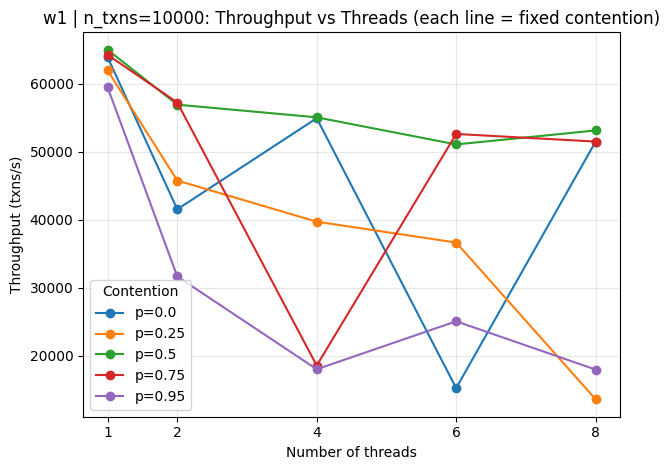

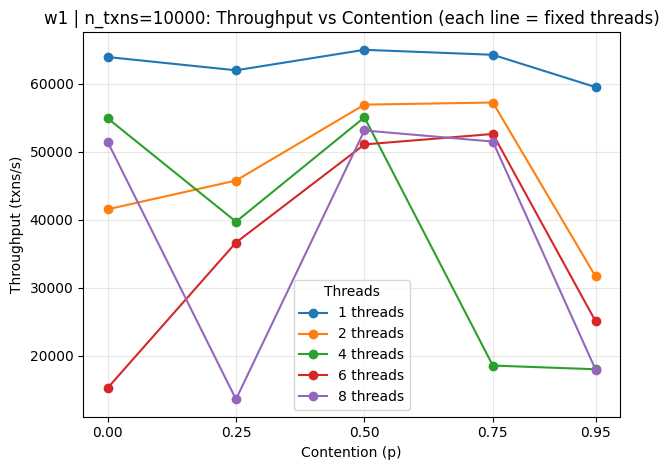

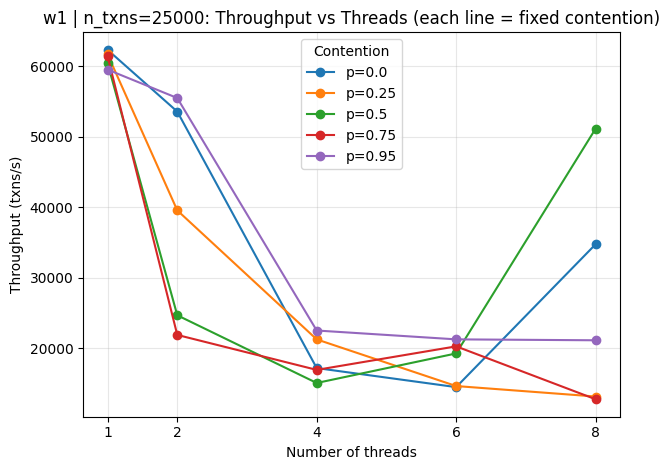

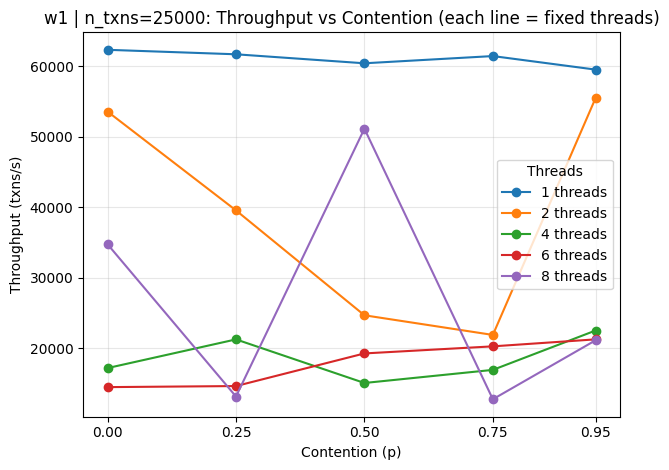

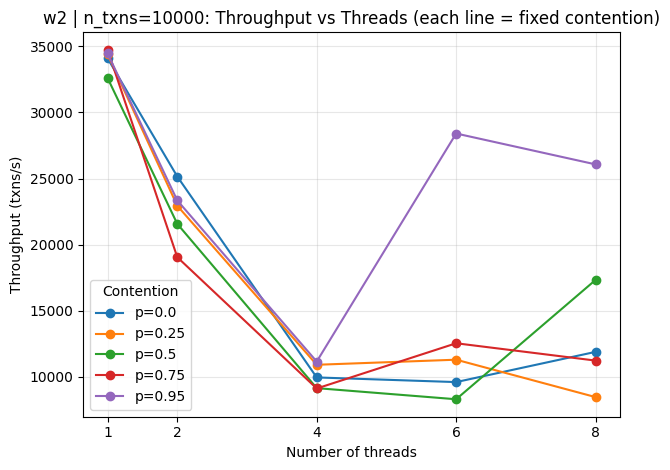

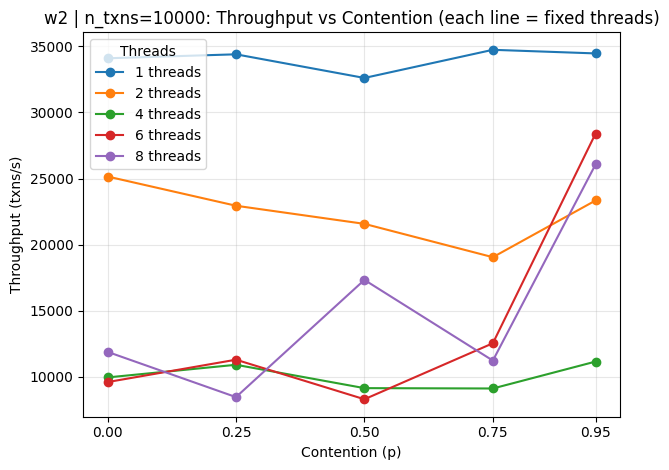

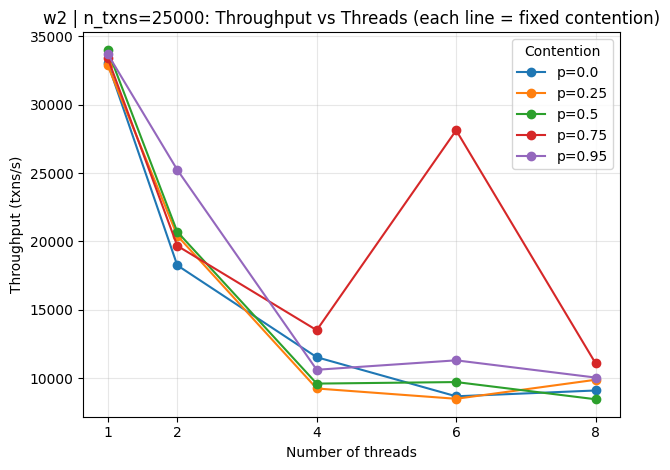

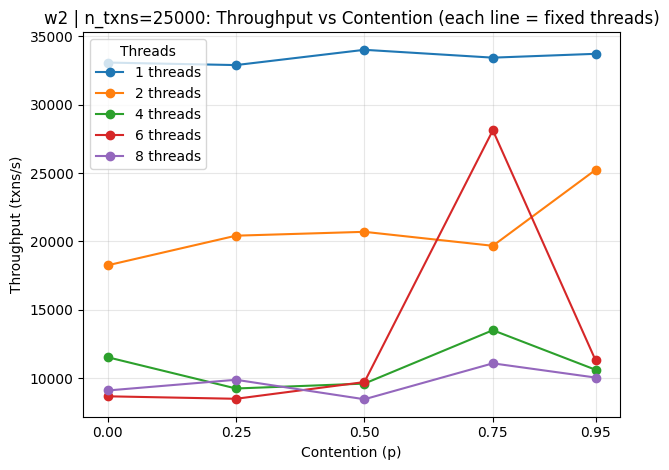

In [46]:
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/223/workloads/benchmark_results.csv")

# Make sure we have throughput
if "txns_per_s" not in df.columns or df["txns_per_s"].isna().all():
    df = df.copy()
    df["txns_per_s"] = df["n_txns"] / df["run_s"]

# Choose which n_txns to visualize (includes the 10-txn case by default)
n_txns_to_plot = [10_000, 25_000]  # edit if you want, e.g. [10, 1000, 10000, 25000]

workloads = sorted(df["workload"].unique())
contentions = sorted(df["contention"].unique())
threads = sorted(df["threads"].unique())

for w in workloads:
    for n_txns in n_txns_to_plot:
        d = df[(df["workload"] == w) & (df["n_txns"] == n_txns)].copy()
        if d.empty:
            print(f"Skipping workload={w}, n_txns={n_txns} (no rows found).")
            continue

        # --- 1) Throughput vs. number of threads (at fixed contention) ---
        plt.figure()
        for p in contentions:
            dp = d[d["contention"] == p].sort_values("threads")
            if dp.empty:
                continue
            plt.plot(dp["threads"], dp["txns_per_s"], marker="o", label=f"p={p}")
        plt.title(f"{w} | n_txns={n_txns}: Throughput vs Threads (each line = fixed contention)")
        plt.xlabel("Number of threads")
        plt.ylabel("Throughput (txns/s)")
        plt.xticks(threads)
        plt.grid(True, alpha=0.3)
        plt.legend(title="Contention")
        plt.tight_layout()
        plt.show()

        # --- 2) Throughput vs. contention (at fixed number of threads) ---
        plt.figure()
        for th in threads:
            dt = d[d["threads"] == th].sort_values("contention")
            if dt.empty:
                continue
            plt.plot(dt["contention"], dt["txns_per_s"], marker="o", label=f"{th} threads")
        plt.title(f"{w} | n_txns={n_txns}: Throughput vs Contention (each line = fixed threads)")
        plt.xlabel("Contention (p)")
        plt.ylabel("Throughput (txns/s)")
        plt.xticks(contentions)
        plt.grid(True, alpha=0.3)
        plt.legend(title="Threads")
        plt.tight_layout()
        plt.show()